<a href="https://colab.research.google.com/github/pietromarini00/30412-Classification-with-LogisticRegression/blob/main/Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DESCRIPTION
----------

This dataset is composed of 1200 samples with 35 features each. The first column
is the sample id. The second column in the dataset represents the label. There
are 5 possible values for the labels. The remaining columns are numeric
features.

Your task is the following: assuming that you want to classify this data with
Logistic Regression (implemented by sklearn.linear_model.LogisticRegression),
you should determine whether applying PCA to this dataset is useful, and if so
what number of components you would choose to use. At the end of the analysis,
you should have chosen an optimal strategy, including the optimal set of
parameters for the classifier: write this choice explicitly in the conclusions
of your notebook.

Your notebook should detail the procedure you have used to choose the optimal
parameters (graphs are a good idea when possible/sensible).

The notebook will be evaluated not only based on the final results, but also on
the procedure employed, which should balance practical considerations (one may
not be able to exhaustively explore all possible combinations of the parameters)
with the desire for achieving the best possible performance in the least amount
of time.

Bonus points may be assigned for particularly clean/nifty code and/or well-
presented results.

You are also free to attempt other strategies beyond the one in the assignment
(which however is mandatory!).

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MaxAbsScaler, MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.model_selection import KFold, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer, f1_score

from sklearn.pipeline import Pipeline

from sklearn.ensemble import VotingClassifier

In [121]:
import warnings
warnings.filterwarnings("ignore")

In [122]:
import pandas as pd
Data = pd.read_csv('mldata_0003094072.csv')

# Data Pre-Processing

In [123]:
labels = Data['label']
features = Data.drop(columns=['Unnamed: 0','label'])

Check if there are any missing values in any column

In [124]:
Data.isnull().any().isnull().any()

False

Now i take out the test set to use later as if I had never seen it

In [125]:
features, X_test, labels, y_test = train_test_split(features, labels, test_size=0.20,train_size=0.80)

Distributions of each feature, they already look Normally distributed

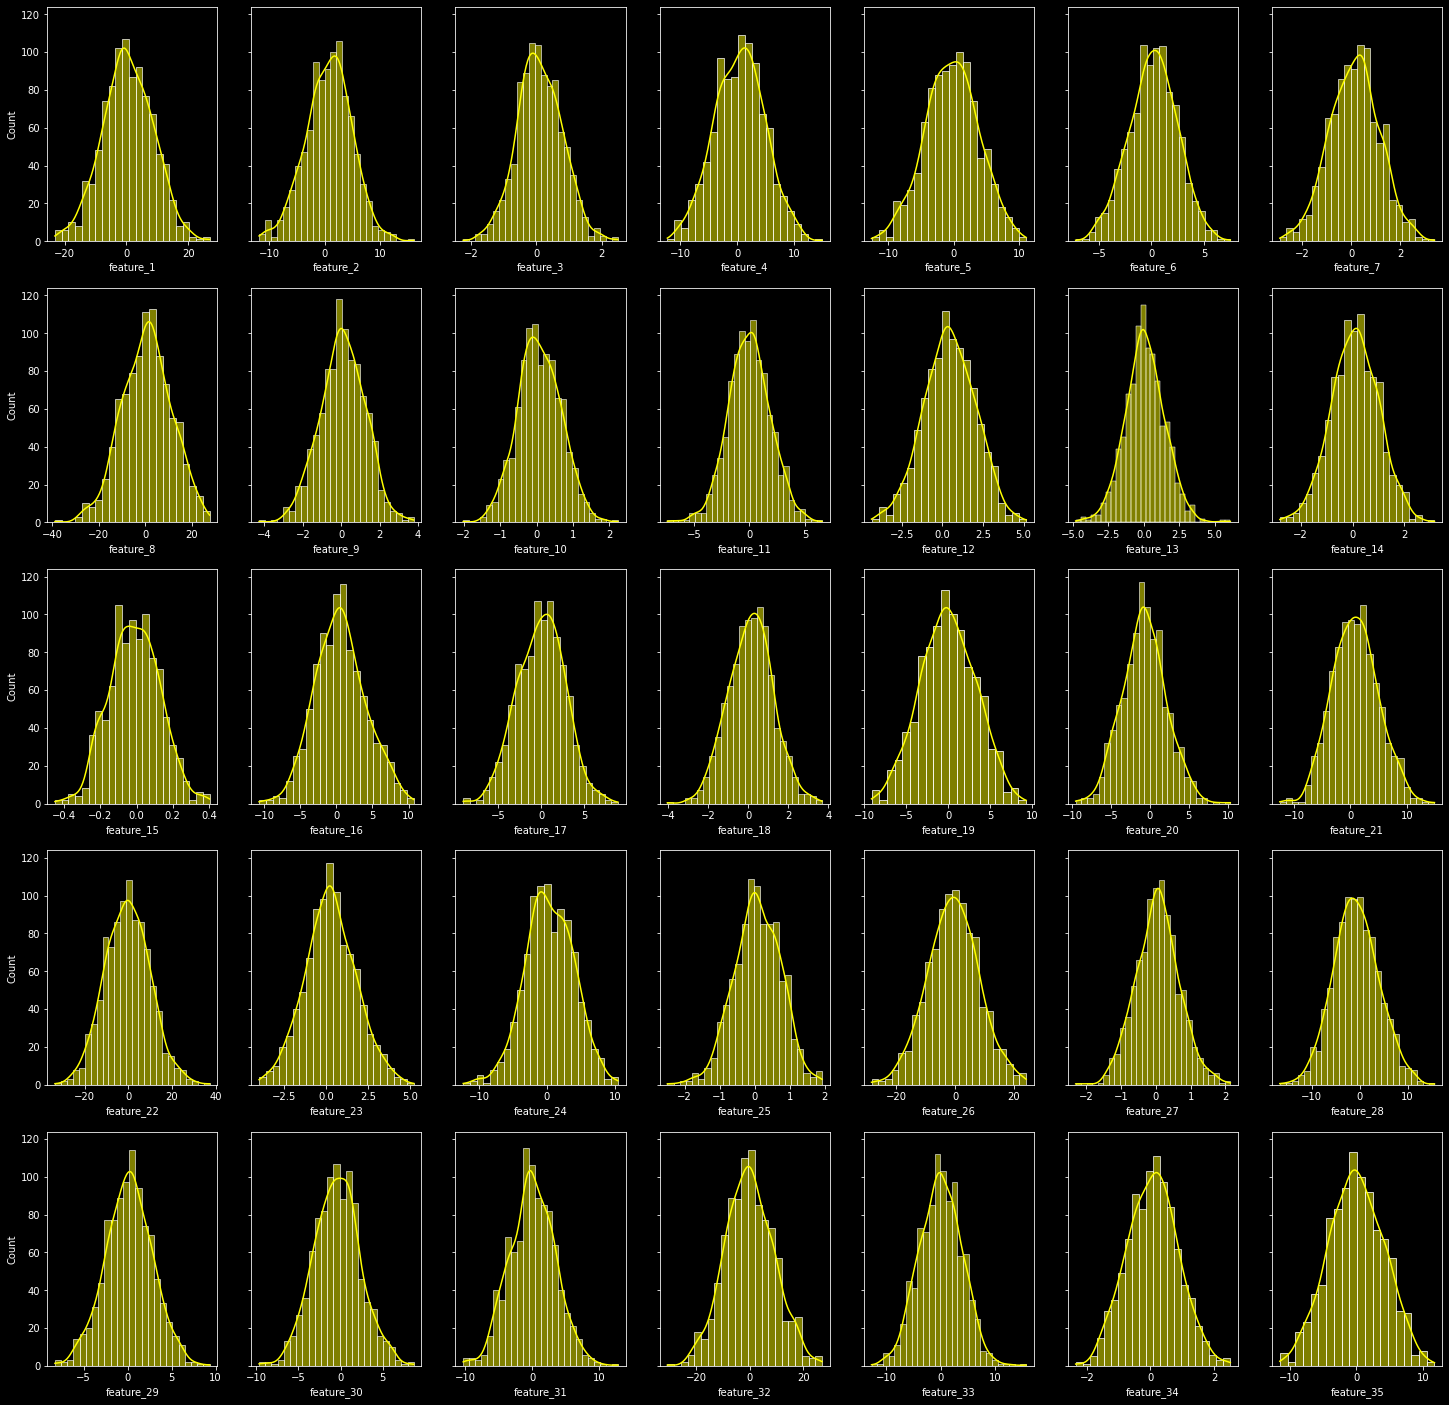

In [126]:
plt.style.use(['dark_background'])
fig, ax = plt.subplots(5,7 , figsize=(25, 25), sharey=True)

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
      sns.histplot(features[features.columns[i*7+j]], ax=ax[i,j],kde=True,color='yellow')

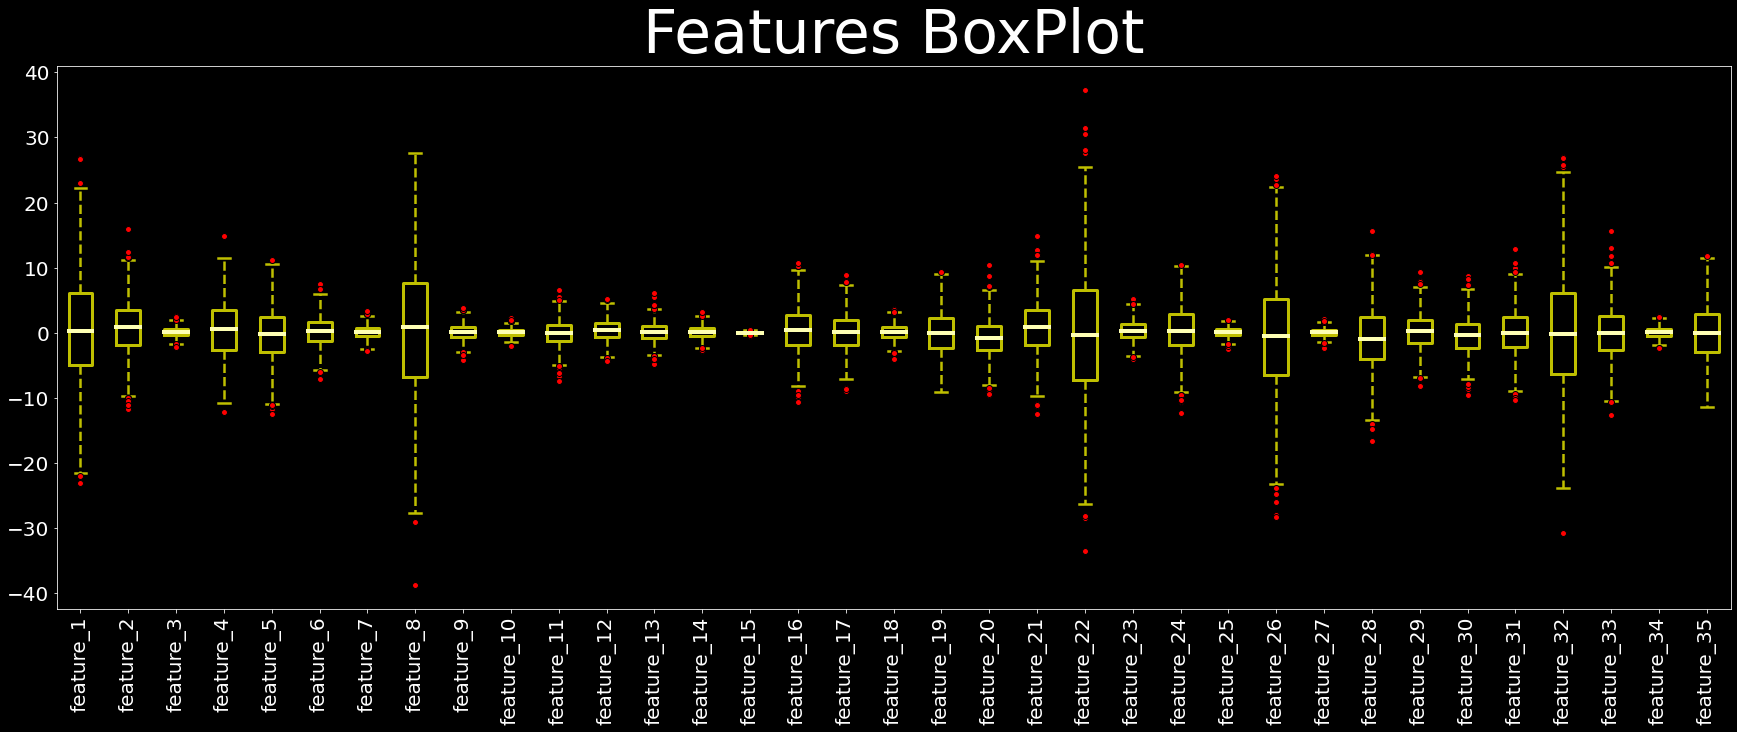

In [127]:
fig = features.boxplot(figsize=(30,10), grid=False, fontsize=20,rot=90, color='y', medianprops = dict(linewidth=4),
                        boxprops = dict(linewidth=3,color='y'), whiskerprops = dict(linestyle='--',linewidth=2.5,color='y'),
                        capprops=dict(color='y',linewidth=2.5), flierprops=dict(marker='o',markerfacecolor='r'))
title = fig.set_title("Features BoxPlot", fontsize=60)

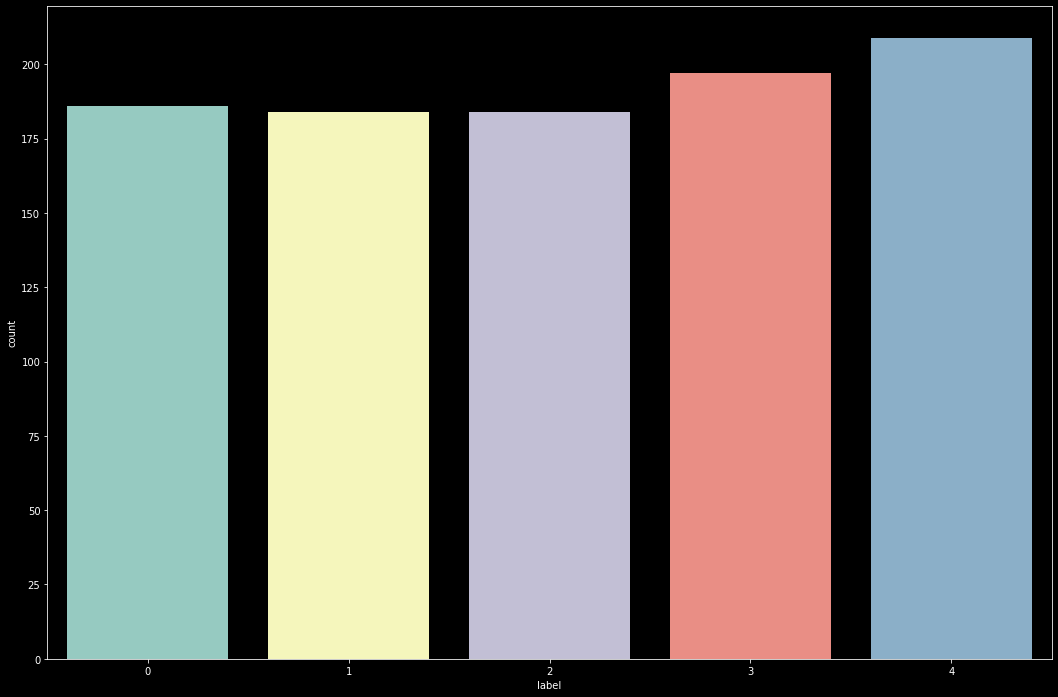

In [128]:
fig = sns.countplot(labels)

In Order to find correlation betweeen labels and classes, I have built a function to OneHot Encode the 5 labels, and calculated the correlation between the binary transformed label and the features.

Then I plotted Everything with another function  that calculates the correlation matrix and plots only the columns corresponding to the labels

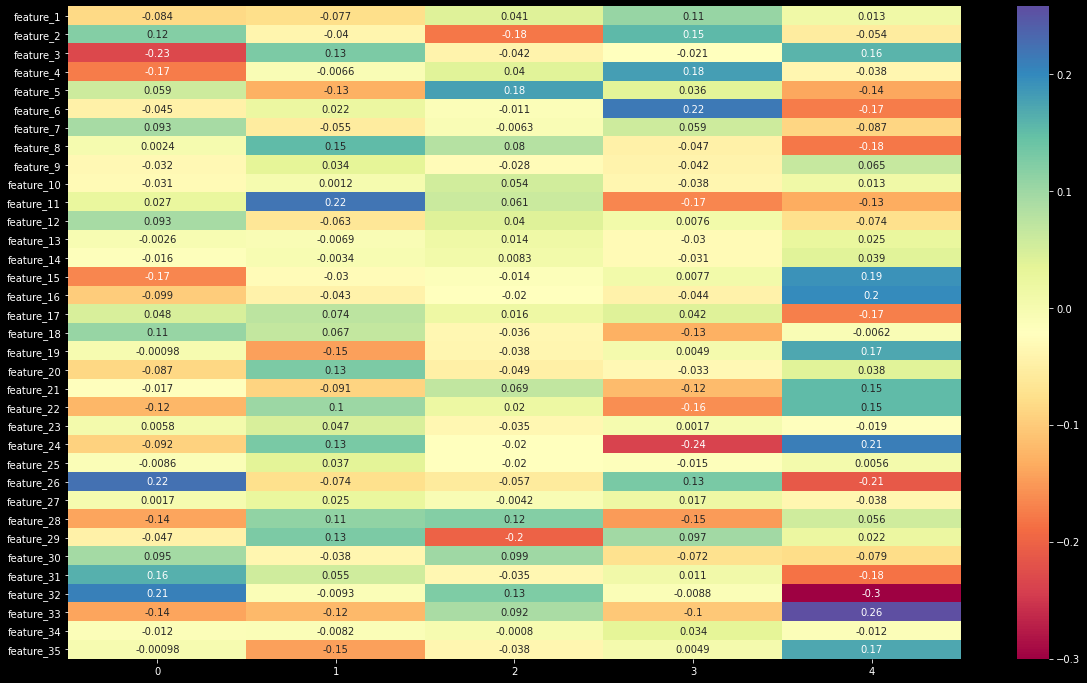

In [129]:
from sklearn.preprocessing import OneHotEncoder

def One_Hot_label_dataframe(features,df):
  enc = OneHotEncoder(handle_unknown='ignore')
  enc_df = pd.DataFrame(enc.fit_transform(df[['label']]).toarray())
  df = df.join(enc_df).drop(columns=['Unnamed: 0','label'])
  return df

def correlation(features,df):
  labels = sorted(df['label'].unique())
  df = One_Hot_label_dataframe(features,df)
  corr_matrix = df.corr()
  map = corr_matrix[labels][:'feature_35']
  fig, ax = plt.subplots(figsize=(20,12))
  sns.heatmap(map, annot=True,ax=ax,cmap='Spectral')
correlation(features,Data)

Principal Component Analysis

1. Normalize the data

PCA is used to identify the components with the maximum variance, and the contribution of each variable to a component is based on its magnitude of variance. It is best practice to normalize the data before conducting a PCA as unscaled data with different measurement units can distort the relative comparison of variance across features.

I tried different Scalers and they printed their accuracy to see if the predictive power decreased after Transforming the data. Nothing Really Happened in terms of performance.

Therefore I opted for Standard Scaler, because of the theoretical considerations above, it would be useful to have centered and standardized data

PCA may serve for the following purposes:
- Visualization (if we can get it down to 2 or 3 dimensions), e.g. for exploratory data analysis 
- Reduce computational load
- Reduce noise

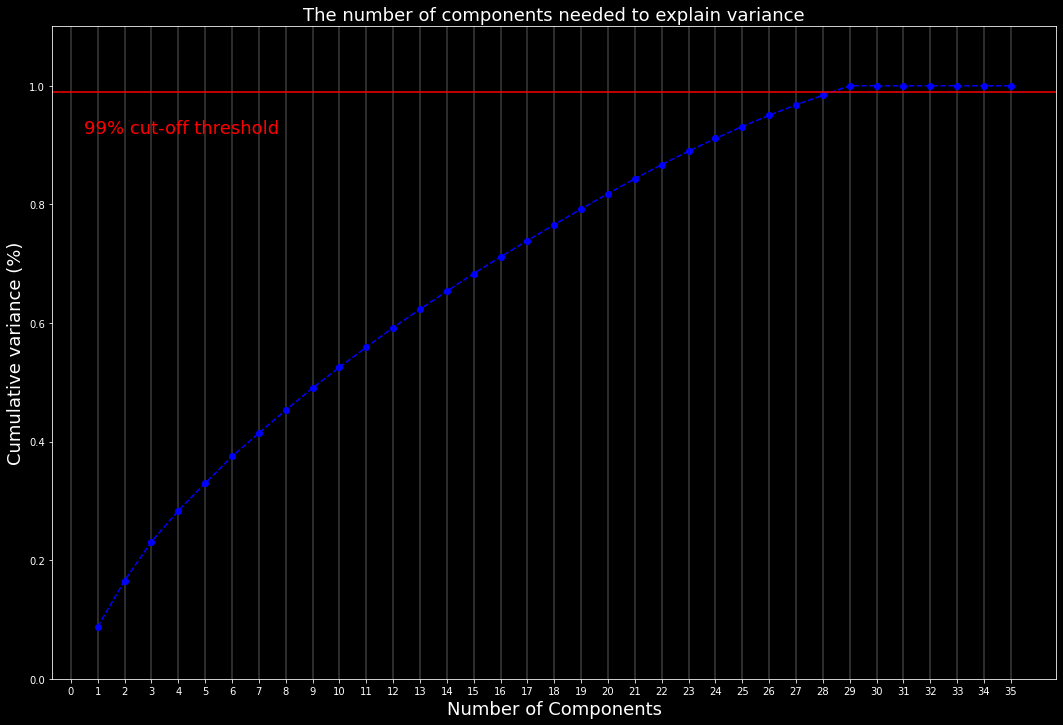

In [130]:
def evaluate_pca_explained_variance(X,scaler=None):
  if scaler is not None:
    X = scaler.fit_transform(X)
  pca = PCA().fit(X)

  plt.rcParams["figure.figsize"] = (18,12)
  fig, ax = plt.subplots()
  xi = np.arange(1, X.shape[1]+1, step=1)
  y = np.cumsum(pca.explained_variance_ratio_)

  plt.ylim(0.0,1.1)
  plt.xlabel('Number of Components', fontsize=18)
  plt.xticks(np.arange(0, 36, step=1))
  plt.ylabel('Cumulative variance (%)',fontsize=18)
  plt.title('The number of components needed to explain variance',fontsize=18)
  plt.plot(xi, y, marker='o', linestyle='--', color='b')
  plt.axhline(y=0.99, color='r', linestyle='-')
  plt.text(0.5, 0.92, '99% cut-off threshold', color = 'red', fontsize=18)

  ax.grid(axis='x',linewidth=0.35)
  plt.show()

evaluate_pca_explained_variance(features,StandardScaler())

The Graph above Plots the Explained Variance as a function of the number of components, and it looks exactly the same for the three scalers, while without scaling the number of components needed to Explain the Variance is Lower (20<29<35)

If we wanted a fixed Cumulative Explained Variance, say 0.95 or 0.99, we could find the number of components even by running manually PCA with Singular Value Decomposition

In [131]:
features_scaled = StandardScaler().fit_transform(features)

svd = np.linalg.svd
def get_number_of_components(X,explainatory_power):
    cov = np.dot(X,X.transpose())/float(X.shape[0])
    U,s,v = svd(cov)
    S_nn = np.cumsum(s)/sum(s)
    return np.sum(S_nn <= explainatory_power)

n_comp = get_number_of_components(features_scaled,0.99)
n_comp

28

However, I want to search exhaustively among the number of components because I dont't know what is the optimal Cumulative Explained Variance giving the number of components which deliver the best result.

Therefore I will run a GridSearch

In [132]:
pca = PCA()
logistic = LogisticRegression(max_iter=10000)
scaler = StandardScaler()
n_comp = np.arange(1,36)

pipe = Pipeline(steps=[('scale',scaler), ('pca', pca), ('logistic', logistic)])
param_grid = {'pca__n_components': n_comp}

search = GridSearchCV(pipe, param_grid, n_jobs=-1,return_train_score=True)
search.fit(features, labels)

print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.548):
{'pca__n_components': 28}


In order to see if we have picked the optimal number of components I will try to understand if they:
- Explain the Variance of the full Dataset 
- Generalize well (test error vs. training error)
- Are Time Efficient


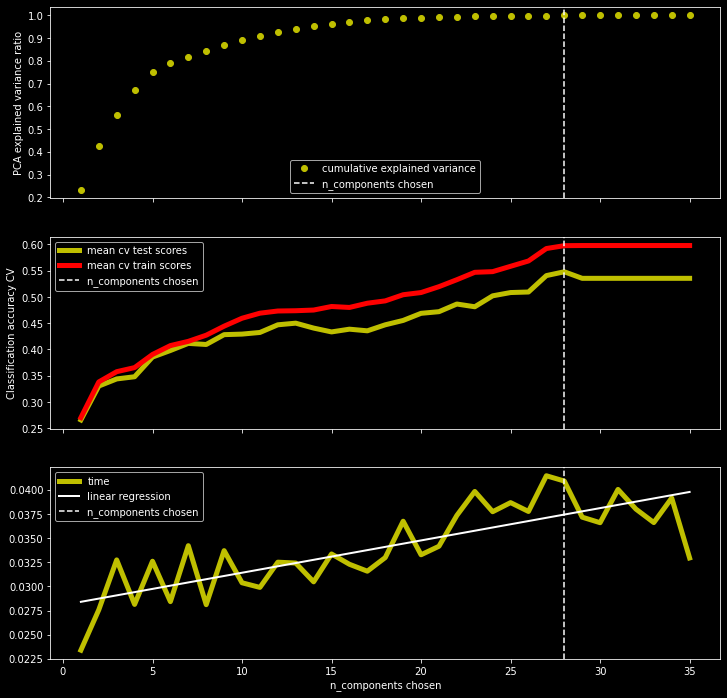

In [133]:
pca.fit(features)
test_scores = search.cv_results_['mean_test_score']
train_scores = search.cv_results_['mean_train_score']
time = search.cv_results_['mean_fit_time']

fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(12, 12))

ax0.set_ylabel('PCA explained variance ratio')
ax0.plot(n_comp,np.cumsum(pca.explained_variance_ratio_), 'o', linewidth=5, color='y', label = 'cumulative explained variance')
ax0.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle='--', label='n_components chosen')
legend = ax0.legend()

ax1.set_ylabel('Classification accuracy CV')
ax1.plot(n_comp,test_scores, '-', linewidth=5, color='y', label='mean cv test scores')
ax1.plot(n_comp,train_scores, '-', linewidth=5, color='r', label='mean cv train scores')
ax1.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle='--', label='n_components chosen')
legend = ax1.legend()

ax2.set_xlabel('n_components chosen')
ax2.plot(n_comp, time, '-', linewidth=5, color='y', label='time')
lin_reg = np.poly1d(np.polyfit(n_comp,time,1))[0]+np.poly1d(np.polyfit(n_comp,time,1))[1]*n_comp
ax2.plot(n_comp,lin_reg ,'-', linewidth=2, color='w',label='linear regression')
ax2.axvline(search.best_estimator_.named_steps['pca'].n_components, linestyle='--', label='n_components chosen')
legend = plt.legend()

From the Plots above we can see that:
- All the Variance is Perfectly captured by 29 components
- Model doesn't generalize perfectly but still we are not overfitting since the accuracy is always increasing in the number of components
- Time is slightly reduced by PCA 

As a result PCA does not have negative effect on predictions, the Accuracy with 29 or 35 components is exactly the same, but since the size of the dataset is reduced, the training and the optimization time is cut by a slight amount that however becomes significant when running a full gird-search, even though the reduction only compresses 35 dimensions into 20 not to lose classification signal.

In [201]:
pca = PCA(n_components = 28)
X_new = pca.fit_transform(features_scaled)

# Model and Hyperparameter Selection

I have written these two functions to explore the parameter space and find the parameters values on which to run the GridSearch. 

In [146]:
def get_params(space):
  params=[]
  for i in space.keys():
    params.append('param_'+i)
  return np.array(params,dtype=str)

def print_top_x(result,x=10):
  best_x = result.cv_results_['rank_test_score'] <= x
  for i in range(x):
    a = dict()
    print('mean test score:', result.cv_results_['mean_test_score'][best_x][i])
    for param in get_params(space):
      a[param]=result.cv_results_[param][best_x][i]
    print(a,'\n')

- Define the model
- Do that with cross validation, in order to get better generalization
- Define the Parameter Space
- Run a randomized search through the parameter space to find the optimal configuration

In [147]:
model = LogisticRegression()
cv = KFold(n_splits=5, random_state=1, shuffle=True)

space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['l1', 'l2']
space['C'] = np.append(np.linspace(10, 100,num=30),np.logspace(-3,1,30),axis=0)
space['multi_class'] = ['ovr','multinomial']
space['fit_intercept'] = [True, False]
space['class_weight'] = ['balanced', None]

search = RandomizedSearchCV(model, space, n_iter=100, scoring='f1_macro', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_new, labels)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_ )


Best Score: 0.5432767833777963
Best Hyperparameters: {'solver': 'liblinear', 'penalty': 'l1', 'multi_class': 'ovr', 'fit_intercept': False, 'class_weight': 'balanced', 'C': 16.20689655172414}


In [93]:
print_top_x(result,3)

mean test score: 0.5344945298727273
{'param_solver': 'liblinear', 'param_penalty': 'l2', 'param_C': 59.6551724137931, 'param_multi_class': 'ovr', 'param_fit_intercept': True, 'param_class_weight': 'balanced'} 

mean test score: 0.5344945298727273
{'param_solver': 'liblinear', 'param_penalty': 'l1', 'param_C': 13.10344827586207, 'param_multi_class': 'ovr', 'param_fit_intercept': True, 'param_class_weight': 'balanced'} 

mean test score: 0.5344945298727273
{'param_solver': 'liblinear', 'param_penalty': 'l2', 'param_C': 3.856620421163472, 'param_multi_class': 'ovr', 'param_fit_intercept': True, 'param_class_weight': 'balanced'} 



I used F_1 score in hyperparameter optimization Because i wanted to improve my recall score (which is still very poor), together with accuracy, and F1 Score = average of recall and accuracy


100 Iterations took:
- 00:20 minutes --> 0.53 Cross Validation F1 Score
Thanks to Scaling and PCA I have reduced the Search Time
- 3:56 minutes --> on full dataset, accuracy 0.54

There is evidently a trade_off, more accuracy costs more time, depending on our needs we should decide whether processing speed >90% reduction is a fair trade-off for losing 1% 
F1_score is high when both accuracy and recall are high

In [148]:
scorer = make_scorer(f1_score, average='macro', greater_is_better=True)

clf = GridSearchCV(LogisticRegression(), {
    'solver': ['liblinear'],
    'penalty': ['l2','l1'],
    'C': np.logspace(-2,2,50),
    'multi_class': ['ovr'],
    'fit_intercept': [True],
    'class_weight': ['balanced']
}, cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, labels)
print('Best Mean Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Mean Score: 0.5507532376877929
Best Hyperparameters: {'C': 1.325711365590108, 'class_weight': 'balanced', 'fit_intercept': True, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}


In [149]:
LRmodel = LogisticRegression(fit_intercept=True, multi_class='ovr', solver = 'liblinear', C=1.325711365590108
                           ,penalty='l2', class_weight='balanced')
LRmodel.fit(X_new, labels)

LogisticRegression(C=1.325711365590108, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In order to see the generalization error, I have to project the Test set on the components that I have found with PCA

Test:  0.5291666666666667 

              precision    recall  f1-score   support

           0       0.42      0.49      0.45        45
           1       0.51      0.44      0.47        48
           2       0.61      0.39      0.48        51
           3       0.53      0.65      0.58        40
           4       0.58      0.68      0.63        56

    accuracy                           0.53       240
   macro avg       0.53      0.53      0.52       240
weighted avg       0.54      0.53      0.52       240



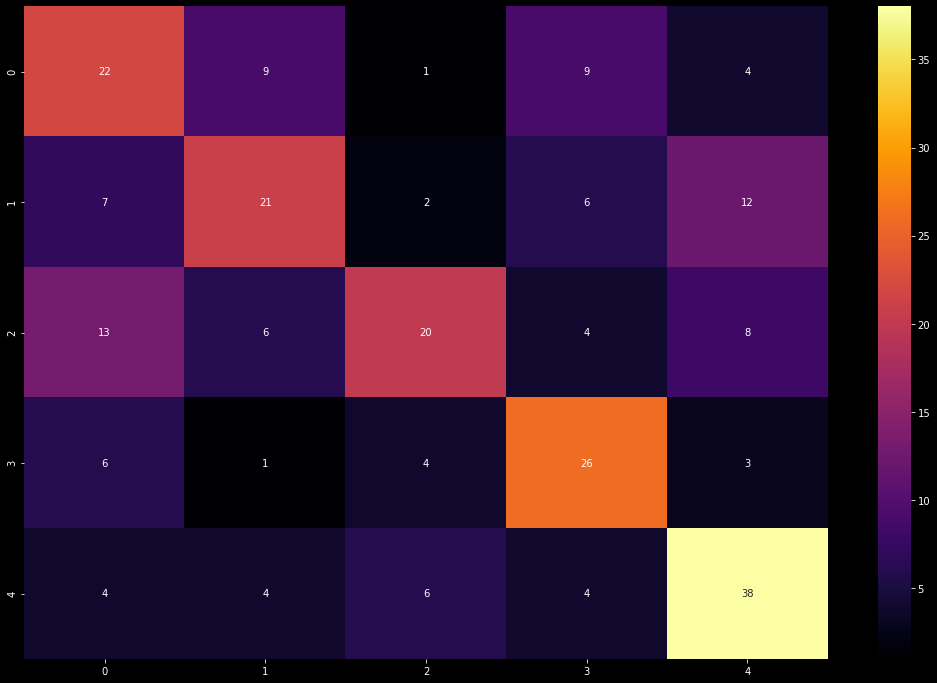

In [193]:
pipe = Pipeline(steps=[('pca', pca), ('logistic', LRmodel)])
pred = pipe.predict(StandardScaler().fit_transform(X_test))

print("Test: ", (accuracy_score(y_test,pred)),'\n')
sns.heatmap(confusion_matrix(y_test,pred), annot=True,cmap='inferno')
print(classification_report(y_test,pred))

In [151]:
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

Y, X = Data['label'], Data.drop(columns=['Unnamed: 0','label'])

Y = label_binarize(Y, classes=[0,1,2,3,4])

X_tr, X_te, Y_tr, Y_te =  train_test_split(X, Y, test_size=.2)

classifier = OneVsRestClassifier(LogisticRegression())
classifier.fit(X_tr, Y_tr)
y_score = classifier.decision_function(X_te)

Average precision score, micro-averaged over all classes: 0.5533200907113005 



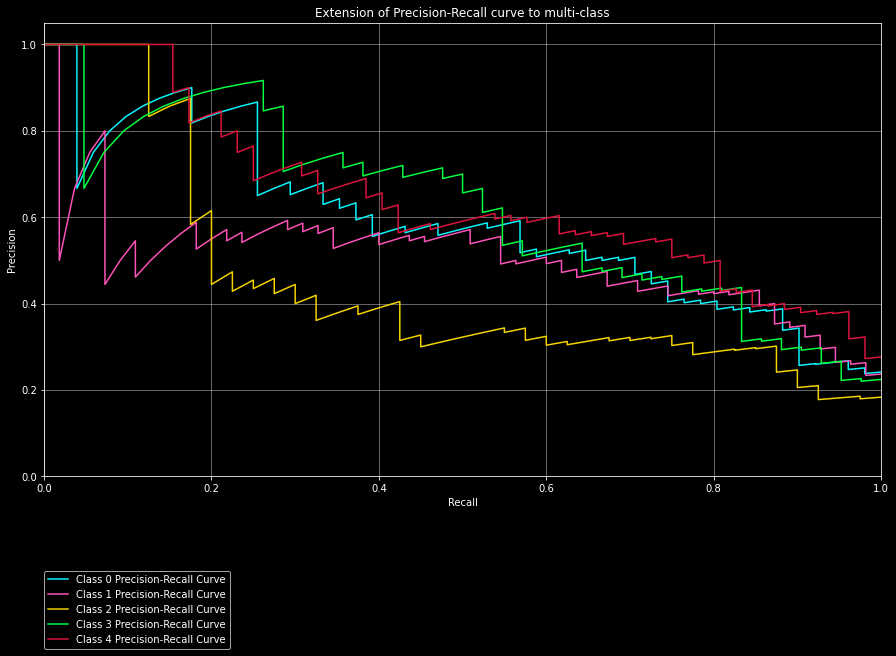

In [152]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

average_precision = dict()
colors = ['#08F7FE', '#FE53BB','#F5D300','#00ff41','crimson']

plt.figure(figsize=(15, 10))

for classs in range(Y.shape[1]):
    precision, recall, _ = precision_recall_curve(Y_te[:, classs], y_score[:, classs])
    average_precision[i] = average_precision_score(Y_te[:, classs], y_score[:, classs])
    plt.plot(recall,precision,color=colors[classs],label=f'Class {classs} Precision-Recall Curve')

# A "micro-average": quantifying score on all classes jointly
average_precision["micro"] = average_precision_score(Y_te, y_score, average="micro")
print(f'Average precision score, micro-averaged over all classes: {average_precision["micro"]}','\n')

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.grid(axis='both',alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
legend = plt.legend(loc=(0, -.38), prop=dict(size=10))

There is something Wrong with Class 2, let's try to see

# Other Models: 
- Support Vector Machine
- Extreme Gradient Boosting (XGBoost)
- Random Forest


In [153]:
model = SVC()
cv = KFold(n_splits=5, random_state=1, shuffle=True)

space = dict()
space['kernel'] = ['linear', 'poly', 'rbf', 'sigmoid']
space['C'] =  np.logspace(-3,2,num=15)/2
space['gamma'] = [1,0.1,0.01,0.005,0.001,0.0005,0.0001]

search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_new, labels)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7135416666666667
Best Hyperparameters: {'kernel': 'rbf', 'gamma': 0.1, 'C': 4.241714491220363}


In [154]:
print_top_x(result,3)

mean test score: 0.7135416666666667
{'param_kernel': 'rbf', 'param_C': 4.241714491220363, 'param_gamma': 0.1} 

mean test score: 0.6822916666666667
{'param_kernel': 'rbf', 'param_C': 50.0, 'param_gamma': 0.005} 

mean test score: 0.69375
{'param_kernel': 'rbf', 'param_C': 21.969852803803974, 'param_gamma': 0.01} 



In [155]:
scorer = make_scorer(accuracy_score, greater_is_better=True)

clf = GridSearchCV(SVC(), {
    'kernel': ['rbf'],
    'C': np.linspace(4,50,num=30),
    'gamma': 7.5*np.logspace(-2,-3,num=20)},
     cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, labels)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7489583333333334
Best Hyperparameters: {'C': 4.0, 'gamma': 0.05885699777635961, 'kernel': 'rbf'}


Test:  0.7666666666666667
[[35  3  2  3  2]
 [ 1 36  4  5  2]
 [ 7  4 36  2  2]
 [ 5  3  2 30  0]
 [ 3  1  1  4 47]]
              precision    recall  f1-score   support

           0       0.69      0.78      0.73        45
           1       0.77      0.75      0.76        48
           2       0.80      0.71      0.75        51
           3       0.68      0.75      0.71        40
           4       0.89      0.84      0.86        56

    accuracy                           0.77       240
   macro avg       0.76      0.76      0.76       240
weighted avg       0.77      0.77      0.77       240



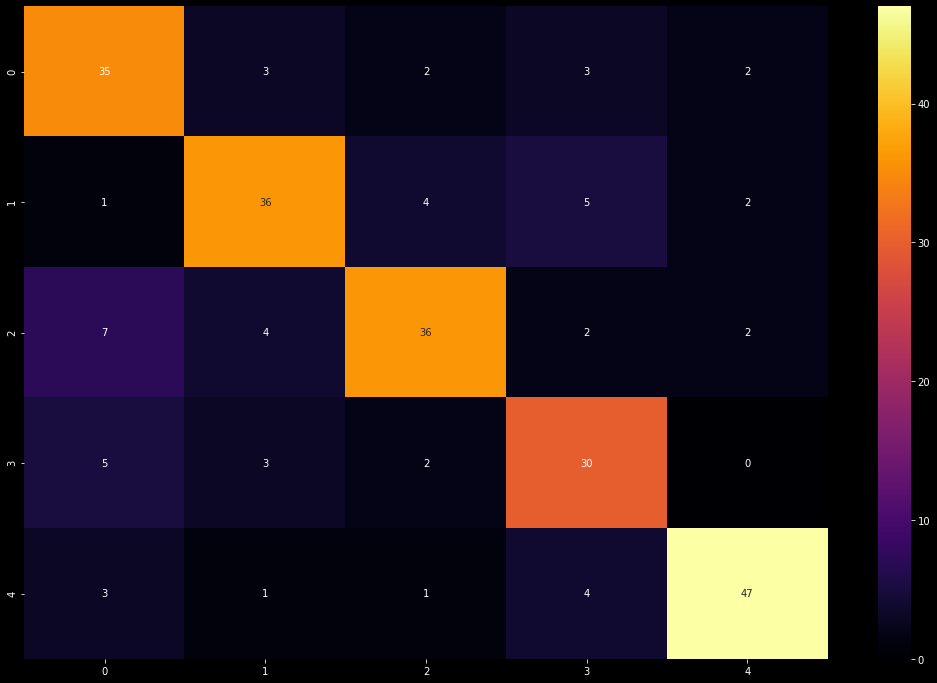

In [194]:
modelSVC = SVC(kernel='rbf', gamma=0.05885699777635961, C = 4.0)
modelSVC.fit(X_new, labels)

pipeSVC = Pipeline(steps=[('pca', pca), ('clf', modelSVC)])
pred = pipeSVC.predict(StandardScaler().fit_transform(X_test))

print("Test: ", (accuracy_score(y_test,pred)))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
sns.heatmap(confusion_matrix(y_test,pred), annot=True,cmap='inferno')

In [183]:
model = XGBClassifier()
cv = KFold(n_splits=5, random_state=1, shuffle=True)

space = dict()
space['eta'] = np.logspace(-2,0,50)
space['max_depth'] = np.logspace(1,2,num=15,dtype=int)//2
space['gamma'] = np.logspace(-6,2,20)
space['subsample'] = [0.5,0.64, 0.72, 0.8, 0.86, 0.92]

search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_new, labels)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.621875
Best Hyperparameters: {'subsample': 0.64, 'max_depth': 13, 'gamma': 0.01623776739188721, 'eta': 0.023299518105153717}


In [185]:
print_top_x(result,3)

mean test score: 0.6197916666666667
{'param_eta': 0.5689866029018296, 'param_max_depth': 13, 'param_gamma': 1.8329807108324375e-05, 'param_subsample': 0.72} 

mean test score: 0.6197916666666667
{'param_eta': 0.12648552168552957, 'param_max_depth': 18, 'param_gamma': 0.00012742749857031334, 'param_subsample': 0.72} 

mean test score: 0.621875
{'param_eta': 0.023299518105153717, 'param_max_depth': 13, 'param_gamma': 0.01623776739188721, 'param_subsample': 0.64} 



In [187]:
scorer = make_scorer(accuracy_score, greater_is_better=True)
clf = GridSearchCV(XGBClassifier(), {
    'eta': [0.023299518105153717,0.12648552168552957,0.5689866029018296],
    'max_depth' : [18,13],
    'gamma' : [0.01623776739188721,0.00012742749857031334, 1.8329807108324375e-05],
    'subsample': [0.72,0.64]},
     cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, labels)

print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6427083333333334
Best Hyperparameters: {'eta': 0.023299518105153717, 'gamma': 0.00012742749857031334, 'max_depth': 18, 'subsample': 0.64}


Test:  0.5916666666666667
[[26  4  3  9  3]
 [ 7 26  2  9  4]
 [11  4 25  3  8]
 [ 9  2  2 25  2]
 [ 5  5  3  3 40]]
              precision    recall  f1-score   support

           0       0.45      0.58      0.50        45
           1       0.63      0.54      0.58        48
           2       0.71      0.49      0.58        51
           3       0.51      0.62      0.56        40
           4       0.70      0.71      0.71        56

    accuracy                           0.59       240
   macro avg       0.60      0.59      0.59       240
weighted avg       0.61      0.59      0.59       240



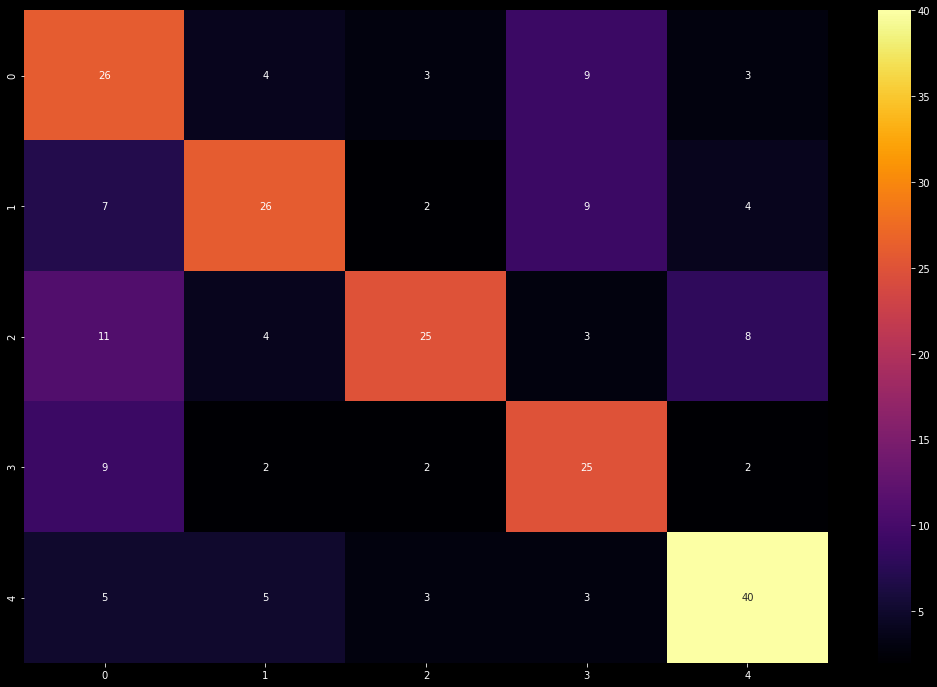

In [195]:
modelXGBC = XGBClassifier(max_depth=18,eta=0.023299518105153717,gamma=0.00012742749857031334,subsample= 0.64)
modelXGBC.fit(X_new, labels)

pipeXGB = Pipeline(steps=[('pca', pca),('clf', modelXGBC)])
pred = pipeXGB.predict(StandardScaler().fit_transform(X_test))

print("Test: ", (accuracy_score(y_test,pred)))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
sns.heatmap(confusion_matrix(y_test,pred), annot=True,cmap='inferno')

In [162]:
# define model
model = RandomForestClassifier()
# define evaluation
cv = KFold(n_splits=5, random_state=1, shuffle=True)
#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# define search space
space = dict()
space['n_estimators'] = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
space['max_features'] = ['auto', 'sqrt']
space['max_depth'] = [int(x) for x in np.linspace(10, 110, num = 11)] + [None]
space['min_samples_split'] = [2, 5, 10]
space['min_samples_leaf'] = [1, 2, 4]
space['bootstrap'] = [True, False]

# define search
search = RandomizedSearchCV(model, space, n_iter=50, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X_new, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
# print out the results of the randomized search

Best Score: 0.6479166666666667
Best Hyperparameters: {'n_estimators': 800, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}


In [163]:
print_top_x(result,3)

mean test score: 0.6479166666666667
{'param_n_estimators': 800, 'param_max_features': 'auto', 'param_max_depth': 100, 'param_min_samples_split': 2, 'param_min_samples_leaf': 1, 'param_bootstrap': False} 

mean test score: 0.64375
{'param_n_estimators': 1400, 'param_max_features': 'sqrt', 'param_max_depth': 60, 'param_min_samples_split': 2, 'param_min_samples_leaf': 1, 'param_bootstrap': True} 

mean test score: 0.64375
{'param_n_estimators': 1600, 'param_max_features': 'auto', 'param_max_depth': 110, 'param_min_samples_split': 2, 'param_min_samples_leaf': 1, 'param_bootstrap': True} 



In [164]:
scorer = make_scorer(accuracy_score, greater_is_better=True)
clf = GridSearchCV(RandomForestClassifier(), {
    'n_estimators':[800,1400,1600],
    'max_depth' : [60,100,110],
    'max_features' : ['sqrt','auto'],
    'min_samples_split': [2],
    'min_samples_leaf' : [1],
    'bootstrap' : [False, True]
}, cv=5, return_train_score=False, scoring=scorer)

result = clf.fit(X_new, labels)
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6572916666666666
Best Hyperparameters: {'bootstrap': False, 'max_depth': 110, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1600}


Test:  0.6458333333333334
[[32  5  3  3  2]
 [ 6 28  1  3 10]
 [10  3 26  4  8]
 [ 9  2  1 26  2]
 [ 5  3  2  3 43]]
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        45
           1       0.68      0.58      0.63        48
           2       0.79      0.51      0.62        51
           3       0.67      0.65      0.66        40
           4       0.66      0.77      0.71        56

    accuracy                           0.65       240
   macro avg       0.66      0.64      0.64       240
weighted avg       0.67      0.65      0.65       240



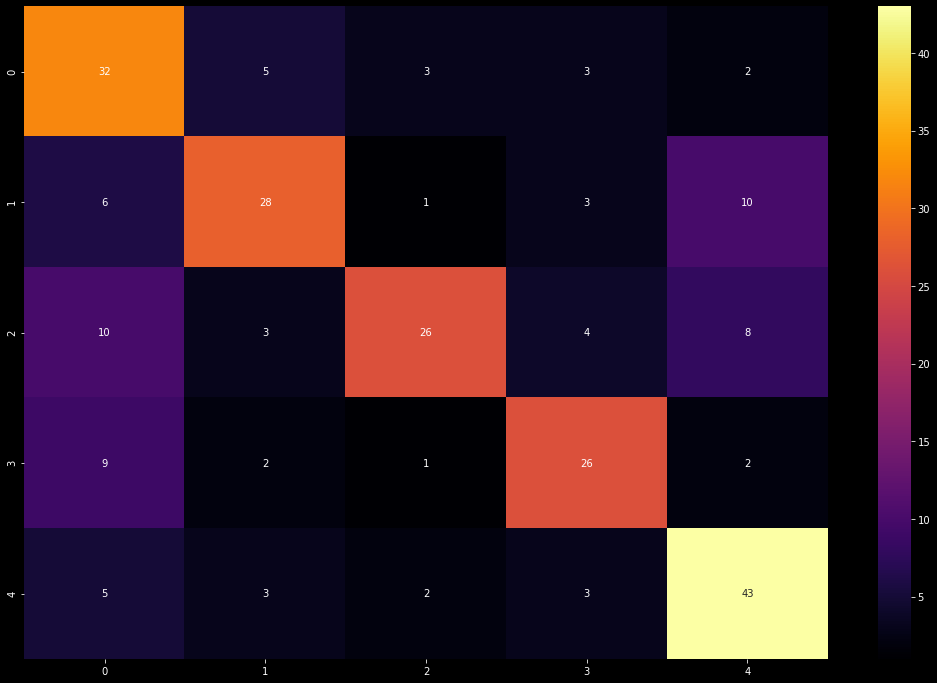

In [196]:
modelRFC = RandomForestClassifier(n_estimators=1600, min_samples_split=2, min_samples_leaf=1,max_features='auto',max_depth=110,bootstrap=False )
modelRFC.fit(X_new, labels)

pipeRFC = Pipeline(steps=[('pca', pca), ('clf', modelRFC)])
pred = pipeRFC.predict(StandardScaler().fit_transform(X_test))

print("Test: ", (accuracy_score(y_test,pred)))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
sns.heatmap(confusion_matrix(y_test,pred), annot=True,cmap='inferno')

Test:  0.6625
[[32  6  2  2  3]
 [ 6 30  2  6  4]
 [11  5 27  4  4]
 [ 9  2  2 26  1]
 [ 4  3  2  3 44]]
              precision    recall  f1-score   support

           0       0.52      0.71      0.60        45
           1       0.65      0.62      0.64        48
           2       0.77      0.53      0.63        51
           3       0.63      0.65      0.64        40
           4       0.79      0.79      0.79        56

    accuracy                           0.66       240
   macro avg       0.67      0.66      0.66       240
weighted avg       0.68      0.66      0.66       240



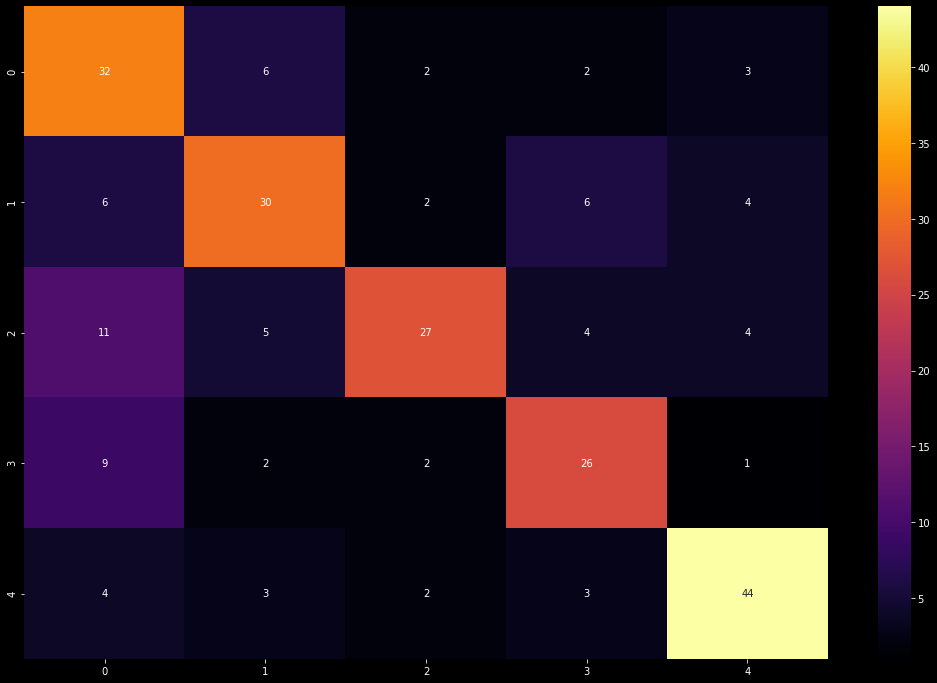

In [202]:
MaxVoting = VotingClassifier(estimators=[('SVC', modelSVC), ('XGBoost', modelXGBC), ('RandomForest', modelRFC),('Logistic regression', LRmodel)], voting='hard')
MaxVoting.fit(X_new,labels)

pred = MaxVoting.predict(pca.transform(StandardScaler().fit_transform(X_test)))

print("Test: ", (accuracy_score(y_test,pred)))
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))
sns.heatmap(confusion_matrix(y_test,pred), annot=True,cmap='inferno')